In [127]:
from awpy import plot
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import FancyBboxPatch
from PIL import Image
import json
from utils.utils import get_teams, get_map, get_players, get_kill_death_occurrences
from utils.stats import analyse_df_clawback_bozo, analyse_df_even, get_ADR, analyse_round_clawback_bozo

In [368]:
# data_directory = "E:/Tier1_2025/BLAST Bounty Season 1/spirit-vs-fnatic-m2-nuke"
data_directory = "BLAST_csv/BLAST_dem3/natus-vincere-vs-imperial-fe-m2-mirage"

ticks = pd.read_csv(os.path.join(data_directory,"ticks.csv"))
rounds = pd.read_csv(os.path.join(data_directory,"rounds.csv"))
kills = pd.read_csv(os.path.join(data_directory,"kills.csv"))
damages = pd.read_csv(os.path.join(data_directory,"damages.csv"))
with open(os.path.join(data_directory,'matchInfo.json'), 'r') as file:
    rounds_dict = json.load(file)


In [359]:
TOURNAMENT = "BLAST BOUNTY SEASON 1"
MATCH_TYPE = "ROUND OF 32"
MAP_NO = 1
SECONDS=20

teams = get_teams(ticks)
teams.sort()

players = get_players(ticks, teams)

print(teams)
team_colors = {
    teams[0]:"#00d75b",
    teams[1]:"#fff243"
}


['Imperial fe', 'Natus Vincere']


In [360]:
def get_position_data(ticks, seconds):
    pos_data = []
    for id,row in rounds.iterrows():
        pos_data.append(ticks[ticks["tick"]==(row["freeze_end"]+seconds*64)])
    return pd.concat(pos_data)
pos_data = get_position_data(ticks, SECONDS)

def get_avg_player_positions():
    points = []
    styles = []
    player_labels = []
    for team in teams:
        for player in players[team]:
            player_pos = pos_data[pos_data["name"]==player]
            ct_pos = player_pos[player_pos["team_name"]=="CT"]
            ct_centroid = (ct_pos["X"].mean(),ct_pos["Y"].mean(),ct_pos["Z"].mean())

            ct_pts = []
            for id,row in ct_pos.iterrows():
                ct_pts.append((row["X"], row["Y"], row["Z"]))
            ct_pts = np.array(ct_pts)

            distances = np.linalg.norm(ct_pts - ct_centroid, axis=1)
            most_average_index = np.argmin(distances)
            most_average_point = ct_pts[most_average_index]

            player_labels.append(player)
            points.append(most_average_point)

            color = team_colors[team]

            styles.append(
                {
                    "marker":'o',
                    "color":color,
                    "size":5,
                    "label":player,
                    # "":False
                }
            )
    return points, styles, player_labels

In [361]:
round_wins_by_economy = {
    teams[0]:{
        "full buy":0,
        "full gun":0,
        "pistols":0,
        "conversions":0,
        "clawback rounds":0
    },
    teams[1]:{
        "full buy":0,
        "full gun":0,
        "pistols":0,
        "conversions":0,
        "clawback rounds":0
    }
}
buy_round_ids = []

# fill the dictionary with data:
previous_pistol = False
previous_winner = None
for id, row in rounds.iterrows():
    T_econ = row["T_average_economy"]
    CT_econ = row["CT_average_economy"]
    round_winner = row["winner_clan_name"]
    
    # print(T_econ, CT_econ, round_winner)
    # pistols
    if T_econ<=1100 and CT_econ<=1100:
        round_wins_by_economy[round_winner]["pistols"] += 1
        previous_pistol = True
        previous_winner = round_winner
    # conversions
    elif previous_pistol:
        if round_winner == previous_winner:
            round_wins_by_economy[round_winner]["conversions"] += 1

        previous_pistol = False
    # buy rounds
    if T_econ>=3800 and CT_econ>=3800:
        round_wins_by_economy[round_winner]["full buy"] += 1
        buy_round_ids.append(id)
    # full guns
    if row["T_full_gun_round"] and row["CT_full_gun_round"]:
        round_wins_by_economy[round_winner]["full gun"] += 1
    
    if not analyse_round_clawback_bozo(kills[kills["round"]==row["round"]], row["winner"]).empty:
        round_wins_by_economy[round_winner]["clawback rounds"] += 1
    
middle_labels = ["clawback rounds", "full buy", ]


left_labels = [f"{round_wins_by_economy[teams[0]]['conversions']}/{round_wins_by_economy[teams[0]]['pistols']}"]
right_labels = [f"{round_wins_by_economy[teams[1]]['conversions']}/{round_wins_by_economy[teams[1]]['pistols']}"]
for label in middle_labels:
    left_labels.append(round_wins_by_economy[teams[0]][label])
    right_labels.append(round_wins_by_economy[teams[1]][label])

middle_labels = ["pistol conversions", "clawback rounds", "full buy rounds"]


In [362]:
cbkdf = analyse_df_clawback_bozo(kills,rounds)
edf = analyse_df_even(kills,rounds)
buy_round_kill_df = kills[kills["round"].isin(buy_round_ids)]
buy_round_damage_df = damages[damages["round"].isin(buy_round_ids)]
points, styles, player_labels = get_avg_player_positions()

In [375]:
# plotting methods

def get_player_substats(team, rounds_played):
    player_stats = {}
    for player in players[team]:
        K,D = get_kill_death_occurrences(kills, player)
        CBK, BD = get_kill_death_occurrences(cbkdf, player)
        EK ,ED = get_kill_death_occurrences(edf, player)
        BRK, BRD = get_kill_death_occurrences(buy_round_kill_df, player)

        player_stats[player] = {
            # "name": player,
            "K": int(K),
            "D": int(D),
            "ADR": round(get_ADR(damages,player,rounds_played),1),
            "BRADR": round(get_ADR(buy_round_damage_df,player,len(buy_round_ids)),1),
            "CBK": int(CBK),
            "BD": int(BD),
            "EK": int(EK),
            "ED": int(ED),
            "BRK": int(BRK),
            "BRD": int(BRD)
        }
    return pd.DataFrame(player_stats).transpose()

def plot_column_with_parenthesis(ax, col_values, par_values, column, start_i = 0, heading="name", is_int=True, is_float=False,step_i=10):
    i = start_i
    for (name,v) in zip(col_values,par_values):
        if is_int:
            name = str(int(name))
            v = str(int(v))
        if is_float:
            name = str("%.1f" % name)
            v = str("%.1f" % v)

        ax.text(column, 0+i, f'{name} ({v})', fontsize=10,
             fontweight="bold", color="black", ha="center", va="center",font="arial")
        i += step_i

    ax.text(column, 0+i, heading.upper(), fontsize=16
            , fontweight="bold", style="italic", color="black", ha="center", va="center",
            font="arial"
            )
def plot_column(ax, col_values, column, start_i = 0, heading="name", is_int=True, is_float=False,step_i=10):
    i = start_i
    for name in col_values:
        if name in ("0/2", "0/1", "0/0", "1/1", "1/2", "2/2"):
            name = name
        elif is_int:
            name = str(int(name))
        elif is_float:
            name = str("%.2f" % name)

        ax.text(column, 0+i, name, fontsize=10,
             fontweight="bold", color="black", ha="center", va="center",font="arial")
        i += step_i

    fontsz = 16
    if heading == "WINS BY ROUND TYPE":
        fontsz = 13
        print(fontsz)
    ax.text(column, 0+i, heading.upper(), fontsize=fontsz
            , fontweight="bold", style="italic", color="black", ha="center", va="center",
            font="arial"
            )

def plot_rounded_rectangle(ax,x, y, width, height, corner_radius, color='#d7d7d7'):


    # Create the rounded rectangle
    rounded_rect = FancyBboxPatch(
        (x, y), width, height,
        boxstyle=f"round,pad=0,rounding_size={corner_radius}",
        edgecolor='black',
        facecolor=color
    )

    # Add the rectangle to the plot
    ax.add_patch(rounded_rect)

def create_team_subplot(ax, team_name, team_score, player_stats):

    # Clear the axis
    ax.clear()

    # Set the background color to a darker shade
    ax.set_facecolor("#ffffff")



    # Remove axis ticks and labels
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
                left=False, labelleft=False)
    plot_rounded_rectangle(ax,-98,73,196,15,10)
    # Add team name and score in white text
    ax.text(0, 80, team_name.upper(), fontsize=30, style="italic",
             fontweight="bold", color="black", ha="center", va="center",
            font="arial"
            )
    plot_rounded_rectangle(ax,-98,5
                           ,196,65,10)
    ax.text(0, 30, str(team_score), fontsize=170, style="italic",fontweight="bold", color="black", ha="center", va="center",font="arial")

    FIRST_TABLE_BOTTOM=-70
    SECOND_TABLE_BOTTOM=-1.2

    plot_column(ax,player_stats.index.values,-75,start_i=FIRST_TABLE_BOTTOM,is_int=False)

    # print(player_stats.index.values)
    y = -40
    for column in ("K","D","ADR","CBK", "BD", "EK", "ED"):
        if column=="K":
            plot_column_with_parenthesis(ax, player_stats[column],player_stats["BRK"],y,start_i=FIRST_TABLE_BOTTOM, heading=column, is_int=True, is_float=False)
            y+=3
        elif column=="D":
            plot_column_with_parenthesis(ax, player_stats[column],player_stats["BRD"],y,start_i=FIRST_TABLE_BOTTOM, heading=column, is_int=True, is_float=False)
            y+=7
        elif column=="ADR":
            plot_column_with_parenthesis(ax,player_stats[column],player_stats["BRADR"],y,start_i=FIRST_TABLE_BOTTOM,heading=column,is_int=False,is_float=True)
            y+=7
        else:
            plot_column(ax,player_stats[column],y,start_i=FIRST_TABLE_BOTTOM,heading=column,is_int=True)

        if column=="CBK":
            y+=5

        y += 18

    title_Y = -8

    ax.text(-15, title_Y, "CLASSIC METRICS\n(FULL BUYS ONLY)", fontsize=10, style="italic",
             fontweight="bold", color="black", ha="center", va="center",
            font="arial"
            )

    # ax.text(-8, title_Y, "(BUY ROUND\nONLY)", fontsize=10, style="italic",
    #          fontweight="bold", color="white", ha="center", va="center",
    #         font="arial"
    #         )

    ax.text(42, title_Y, "CLAWBACK-\n-BOZO", fontsize=10, style="italic",
             fontweight="bold", color="black", ha="center", va="center",
            font="arial"
            )

    ax.text(79, title_Y, "EVEN\n STATES", fontsize=10, style="italic",
             fontweight="bold", color="black", ha="center", va="center",
            font="arial"
            )
    plot_rounded_rectangle(ax,-98,-75
                           ,196,75,10)
    # ax.text(-50,-50,"a")
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    # print(ax.get_xlim())
    # print(ax.get_ylim())

def embed_png_at_coordinates(ax_target, png_file_path, x, y, width, height, crop_pixels=0):
    # Load the PNG file as an image
    image = Image.open(png_file_path)

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Optionally crop the image
    if crop_pixels > 0:
        image_array = image_array[
            crop_pixels:image_array.shape[0] - crop_pixels,  # Crop top and bottom
            crop_pixels:image_array.shape[1] - crop_pixels,  # Crop left and right
        ]

    # Place the image on the target axis
    ax_target.imshow(image_array, extent=(x, x + width, y, y + height), zorder=5)
    ax_target.axis("on")  # Keep axes visible if needed

def embed_image_at_coordinates(fig, ax_target, x, y, width, height, crop_pixels=0):
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Get the rendered figure as a numpy array with ARGB format
    image = np.frombuffer(canvas.tostring_argb(), dtype='uint8')
    canvas_width, canvas_height = canvas.get_width_height()
    image = image.reshape(canvas_height, canvas_width, 4)  # 4 channels for ARGB

    if crop_pixels > 0:
        image = image[
            crop_pixels:canvas_height - crop_pixels,  # Crop top and bottom
            crop_pixels:canvas_width - crop_pixels,  # Crop left and right
        ]

    # Convert ARGB to RGBA (matplotlib expects RGBA format)
    image = image[..., [1, 2, 3, 0]]  # Rearrange channels

    # Place the image on the target axis
    ax_target.imshow(image, extent=(x, x + width, y, y + height), zorder=5)
    ax_target.axis("on")  # Keep axes visible if needed


13


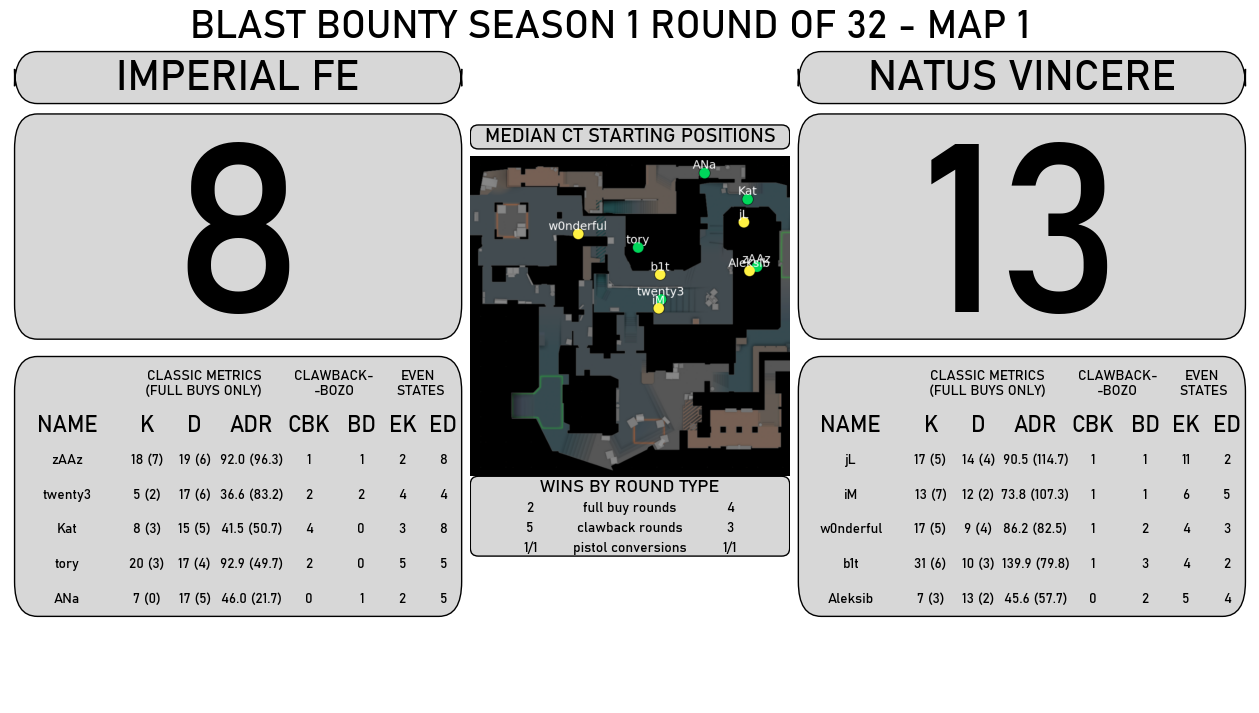

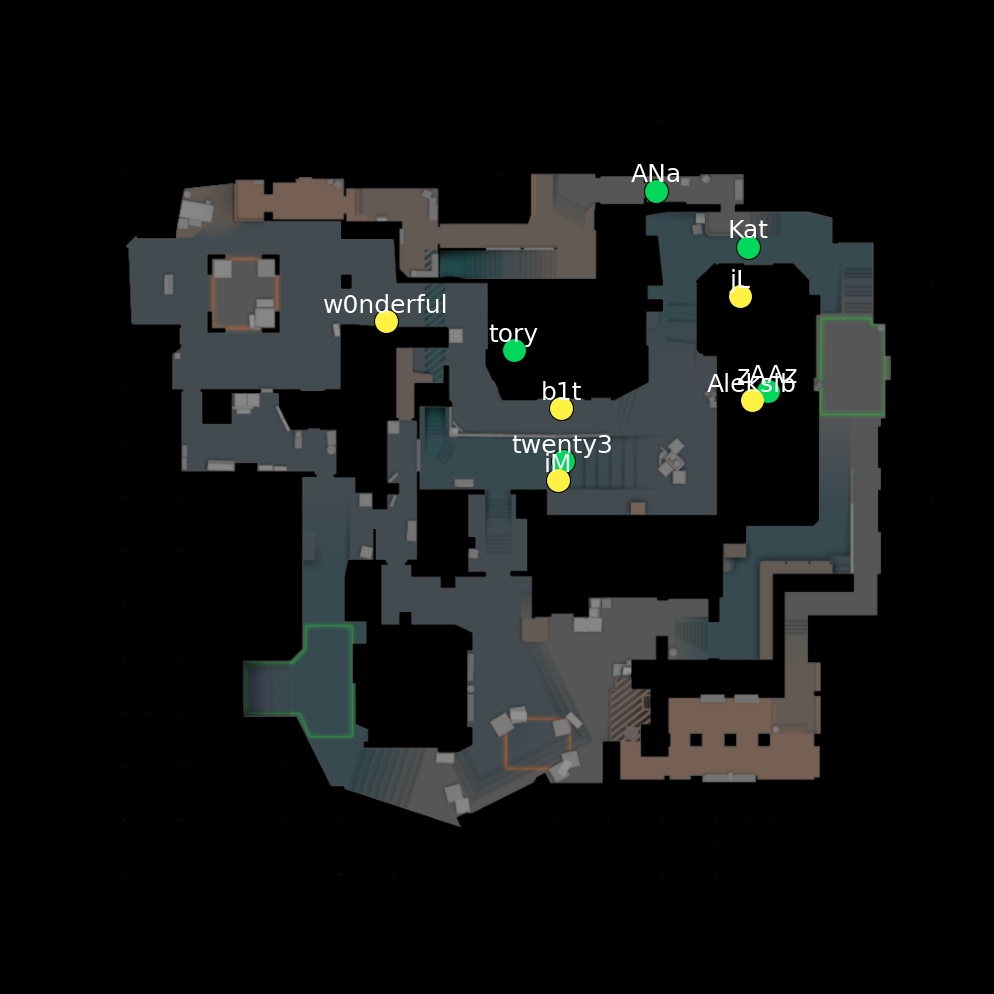

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,9), gridspec_kw={'width_ratios': [1, 0.7, 1]})
plt.subplots_adjust(wspace=0.01, hspace=0.01)
# Create subplots
team_stats_A =get_player_substats(teams[0], rounds_dict["rounds"][teams[0]]["roundsPlayed"])
team_stats_A = team_stats_A.sort_values("BRADR")
team_stats_B =get_player_substats(teams[1], rounds_dict["rounds"][teams[1]]["roundsPlayed"])
team_stats_B = team_stats_B.sort_values("BRADR")

create_team_subplot(axes[0], teams[0], rounds_dict["rounds"][teams[0]]["roundsWon"], team_stats_A)

map = get_map(data_directory)
# map = "nuke"
mapfig,mapax = plot.plot(f"de_{map}",points,styles)
# mapfig.set_size_inches(3,3)
if map=="nuke":
    crop = 250
elif map=="inferno":
    crop = 100
elif map=="dust2":
    crop = 100
else:
    crop = 170
embed_image_at_coordinates(mapfig, axes[1], x=-200, y=50, width=400, height=400, crop_pixels=crop)
# embed_png_at_coordinates(axes[1],"test.png",x=-200, y=50, width=400, height=400, crop_pixels=crop)
# fig.set_size_inches(5,5)
# embed_figure_to_subplot(mapfig, axes[1])

create_team_subplot(axes[2], teams[1], rounds_dict["rounds"][teams[1]]["roundsWon"], team_stats_B)

fig.suptitle(f"{TOURNAMENT} {MATCH_TYPE} - MAP {MAP_NO}", fontsize=28, fontweight="bold", y=0.88, color="black", style="italic",
             font="arial"
             )

axes[1].set_xlim(-200,200)
axes[1].set_ylim(-100,500)
axes[1].text(0,475,"MEDIAN CT STARTING POSITIONS", ha="center", va="center",color="black",  fontsize=14, fontweight="bold",style="italic",
             font="arial"
             ) #0,475
plot_rounded_rectangle(axes[1],-200,460,400,30,10)
# plot_rounded_rectangle(axes[1],-200,-100,400,50,10)

plot_column(axes[1],middle_labels,0,-40,"WINS BY ROUND TYPE", False,step_i=25)
plot_column(axes[1],left_labels,-125,-40,"",step_i=25)
plot_column(axes[1],right_labels,125,-40,"",step_i=25)
plot_rounded_rectangle(axes[1],-200,-50,400,100,10)

# axes[1].clear()

    # Set the background color to a darker shade
axes[1].set_facecolor("#ffffff")

# Remove axis ticks and labels
for spine in axes[1].spines.values():
    spine.set_visible(False)
axes[1].tick_params(bottom=False, labelbottom=False,
            left=False, labelleft=False)
fig.patch.set_facecolor("#ffffff")
# plt.savefig("test.png")
plt.show()

In [370]:
AWP_KDs= {
    "w0nderful": [0,0],
    "ANa" : [0,0]
}

In [371]:


for id, row in kills.iterrows():
    if "AWP" in row["victim_inventory"]:
        if row["victim_name"] in AWP_KDs:
            AWP_KDs[row["victim_name"]][1] += 1
    if "awp" == row["weapon"]:
        if row["attacker_name"] in AWP_KDs:
            AWP_KDs[row["attacker_name"]][0] += 1
AWP_KDs

{'w0nderful': [5, 1], 'ANa': [3, 7]}

In [354]:
K ANa
D ANa ak47
K ANa
D ANa ak47
D ANa ak47
K b1t
D w0nderful deagle
K ANa
D ANa ak47
D ANa deagle
K w0nderful
D ANa ak47
K w0nderful
K w0nderful
D ANa awp
K w0nderful
K w0nderful

Index(['Unnamed: 0', 'tick', 'assistedflash', 'dmg_health', 'dmg_armor',
       'attackerblind', 'headshot', 'hitgroup', 'noscope', 'penetrated',
       'thrusmoke', 'is_bomb_planted', 'weapon', 'assister_X', 'assister_Y',
       'assister_Z', 'assister_pitch', 'assister_yaw',
       'assister_last_place_name', 'assister_flash_duration',
       'assister_health', 'assister_armor_value',
       'assister_current_equip_value', 'assister_has_defuser',
       'assister_has_helmet', 'assister_inventory', 'assister_ping',
       'assister_team_name', 'assister_team_clan_name', 'assister_name',
       'assister_steamid', 'attacker_X', 'attacker_Y', 'attacker_Z',
       'attacker_pitch', 'attacker_yaw', 'attacker_last_place_name',
       'attacker_flash_duration', 'attacker_health', 'attacker_armor_value',
       'attacker_current_equip_value', 'attacker_has_defuser',
       'attacker_has_helmet', 'attacker_inventory', 'attacker_ping',
       'attacker_team_name', 'attacker_team_clan_name', 'a